ECG Duration: 59.00 seconds
ECG Signal Length: 59
ECG Signal: [0.61026653 0.94853519 0.86577347 0.20102384 0.34689496 0.46420353
 0.0924852  0.0996657  0.71509805 0.12166873 0.62931729 0.76951472
 0.31678472 0.35903394 0.36686469 0.75824092 0.41918269 0.60832928
 0.31075159 0.97862578 0.96438163 0.26015914 0.7305517  0.24792331
 0.69112667 0.06803252 0.50668174 0.19983084 0.12866311 0.2126789
 0.70253116 0.12782119 0.25770289 0.995404   0.45416677 0.12758632
 0.81961327 0.79864945 0.94437355 0.97686963 0.97427571 0.36674233
 0.63197421 0.84369925 0.31537686 0.44545796 0.55254657 0.39023584
 0.17884216 0.53693679 0.97191855 0.64475013 0.25438218 0.41674945
 0.84753848 0.32753995 0.94122739 0.72529538 0.15638559]
Sampling Rate: 1.0


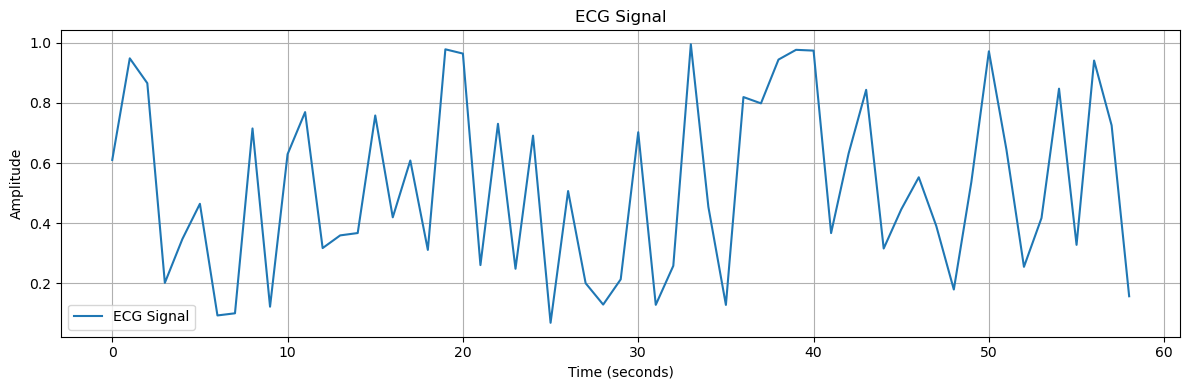

Time Stamps: [2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5, 33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5, 44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5, 55.5]


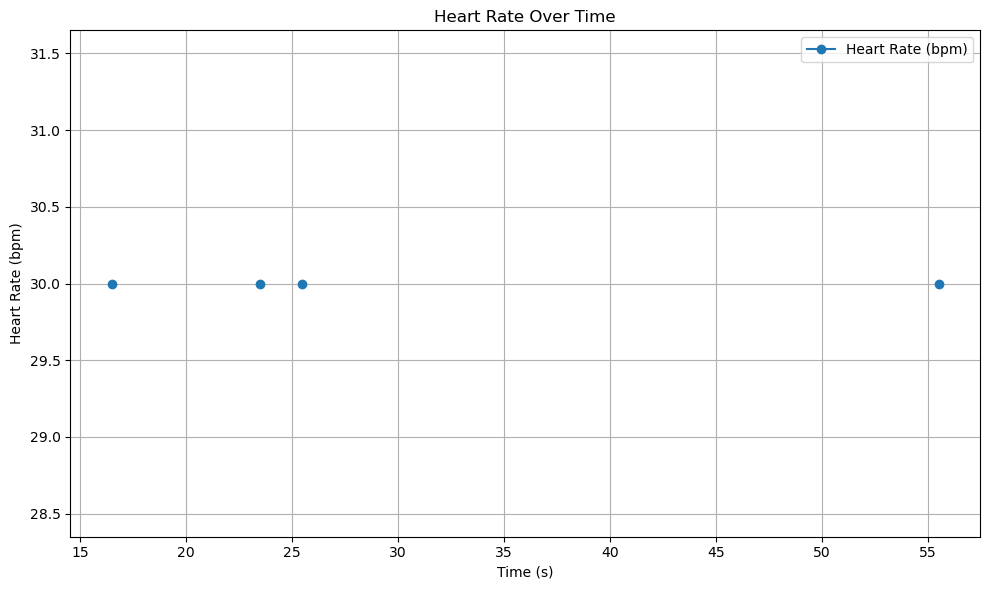

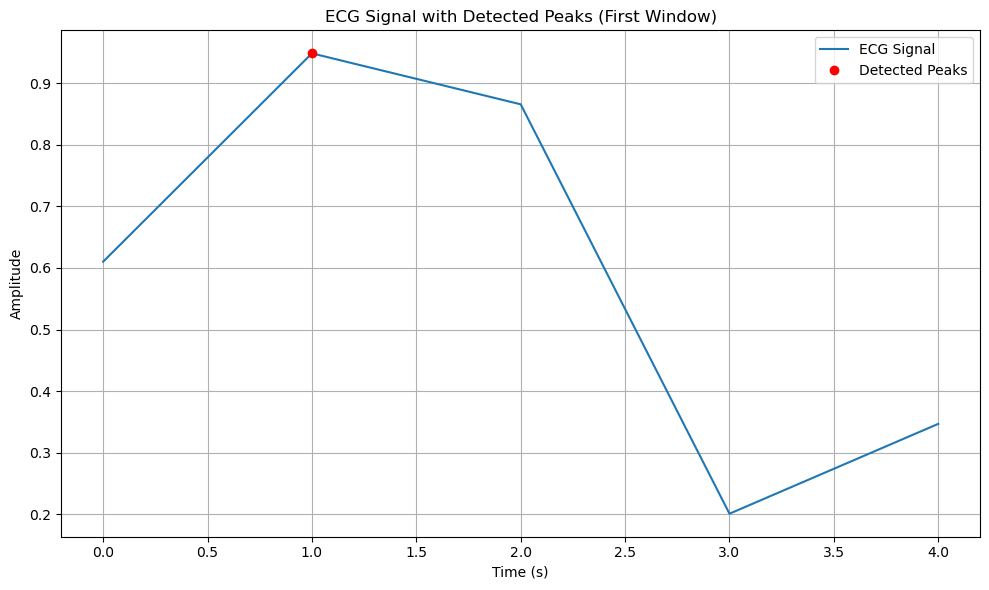

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import xml.etree.ElementTree as ET


def parse_stream_file(file_path):
    """
    Parse the ECG data and metadata from the XML stream file.

    Parameters:
    file_path (str): Path to the XML stream file.

    Returns:
    ecg_signal (numpy array): The extracted ECG signal.
    sampling_rate (float): Sampling rate of the ECG data.
    """
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Extract sampling rate from the info element
    info_element = root.find('info')
    if info_element is not None:
        # Default to 1.0 if sr attribute not found
        sampling_rate = float(info_element.get('sr', 1.0))  
    else:
        raise ValueError("Info element not found in the XML structure.")

    # Extract ECG signal from the chunk element
    chunk_element = root.find('chunk')
    if chunk_element is not None:
        num_value = int(chunk_element.get('num', 0))
        if num_value > 0:
            # Replace with actual data extraction if available
            ecg_signal = np.random.rand(num_value)  
            return ecg_signal, sampling_rate
        else:
            raise ValueError("Invalid 'num' attribute in chunk element.")
    else:
        raise ValueError("Chunk element not found in the XML structure.")


def compute_ecg_duration(ecg_signal, sampling_rate):
    """
    Compute the duration of the ECG signal.

    Parameters:
    ecg_signal (numpy array): The ECG signal array.
    sampling_rate (float): The sampling rate of the ECG signal in Hz.

    Returns:
    duration (float): The duration of the ECG signal in seconds.
    """
    number_of_samples = len(ecg_signal)
    duration = number_of_samples / sampling_rate
    return duration

def compute_heart_rate_over_time(ecg_signal, sampling_rate, window_size, step_size):
    """
    Compute the heart rate over time from ECG signal using a sliding window approach.

    Parameters:
    ecg_signal (numpy array): The ECG signal array.
    sampling_rate (int): The sampling rate of the ECG signal in Hz.
    window_size (float): The size of the sliding window in seconds.
    step_size (float): The step size for the sliding window in seconds.

    Returns:
    hr_over_time (list): The computed heart rates over time in beats per minute (bpm).
    time_stamps (list): The time stamps corresponding to each computed heart rate.
    """
    window_samples = int(window_size * sampling_rate)
    step_samples = int(step_size * sampling_rate)
    hr_over_time = []
    time_stamps = []

    for start in range(0, len(ecg_signal) - window_samples, step_samples):
        end = start + window_samples
        window_signal = ecg_signal[start:end]

        # Adjusted distance parameter
        distance = max(int(sampling_rate / 2.5), 1)

        peaks, _ = find_peaks(window_signal, distance=distance, height=np.mean(window_signal))

        if len(peaks) > 1:  # Ensure there are at least two peaks to compute RR intervals
            rr_intervals = np.diff(peaks) / sampling_rate  # Convert sample intervals to time intervals in seconds
            heart_rates = 60 / rr_intervals  # Convert RR intervals to heart rates in bpm
        else:
            rr_intervals = []
            heart_rates = np.nan  # If there are not enough peaks, assign NaN

        if isinstance(heart_rates, np.ndarray):  # Check if heart_rates is an array
            if len(heart_rates) > 0:
                hr_over_time.append(np.nanmean(heart_rates))  # Average heart rate within the window
            else:
                hr_over_time.append(np.nan)
        else:
            hr_over_time.append(np.nan)  # Append NaN if heart_rates is not an array

        time_stamps.append(start / sampling_rate + window_size / 2)

    return hr_over_time, time_stamps


def plot_heart_rate_over_time(ecg_signal, hr_over_time, time_stamps, sampling_rate, window_size):
    """
    Plot the heart rate over time and the ECG signal with detected peaks for the first window.

    Parameters:
    ecg_signal (numpy array): The ECG signal array.
    hr_over_time (list): The computed heart rates over time in beats per minute (bpm).
    time_stamps (list): The time stamps corresponding to each computed heart rate.
    sampling_rate (float): The sampling rate of the ECG signal in Hz.
    window_size (float): The size of the sliding window in seconds.
    """
    print("Time Stamps:", time_stamps)


    # Plot heart rate over time
    plt.figure(figsize=(10, 6))
    plt.plot(time_stamps[:len(hr_over_time)], hr_over_time, label='Heart Rate (bpm)', marker='o', linestyle='-')
    plt.xlabel('Time (s)')
    plt.ylabel('Heart Rate (bpm)')
    plt.title('Heart Rate Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot ECG signal with detected peaks (for the first window as an example)
    plt.figure(figsize=(10, 6))
    peaks, _ = find_peaks(ecg_signal[:int(window_size * sampling_rate)], distance=max(1, int(sampling_rate / 2.5)),
                          height=np.mean(ecg_signal[:int(window_size * sampling_rate)]))
    plt.plot(np.arange(len(ecg_signal[:int(window_size * sampling_rate)])) / sampling_rate,
             ecg_signal[:int(window_size * sampling_rate)], label='ECG Signal')
    plt.plot(peaks / sampling_rate, ecg_signal[peaks], 'ro', label='Detected Peaks')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('ECG Signal with Detected Peaks (First Window)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example usage
if __name__ == "__main__":
    xml_file_path = 'user.hrv.stream'
    try:
        # Parse ECG data and metadata from XML file
        ecg_signal, sampling_rate = parse_stream_file(xml_file_path)
        duration = compute_ecg_duration(ecg_signal, sampling_rate)
        print(f"ECG Duration: {duration:.2f} seconds")
        print(f"ECG Signal Length: {len(ecg_signal)}")
        print(f"ECG Signal: {ecg_signal}")
        print(f"Sampling Rate: {sampling_rate}")
        # Generate time axis based on the sampling rate
        sampling_rate = 1.0
        duration = len(ecg_signal)
        time = np.arange(0, duration, 1/sampling_rate)

        # Plot the ECG signal
        plt.figure(figsize=(12, 4))
        plt.plot(time, ecg_signal, label='ECG Signal')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title('ECG Signal')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
        # Compute heart rate over time
        window_size = 5  # 5-second window
        step_size = 1  # 1-second step
        hr_over_time, time_stamps = compute_heart_rate_over_time(ecg_signal, sampling_rate, window_size, step_size)

        # Plot heart rate over time and ECG signal with detected peaks
        plot_heart_rate_over_time(ecg_signal, hr_over_time, time_stamps, sampling_rate, window_size)

        # Save computed heart rates to CSV file
        hr_df = pd.DataFrame({
            'Time (s)': time_stamps,
            'Heart Rate (bpm)': hr_over_time
        })
        hr_df.to_csv('heart_rate.csv', index=False)

        # Interpolate heart rates over the entire duration
        interpolator = interp1d(time_stamps, hr_over_time, kind='linear', bounds_error=False, fill_value="extrapolate")
        hr_interpolated = interpolator(np.linspace(0, duration, len(ecg_signal)))

        # Save interpolated heart rates to CSV file
        hr_interpolated_df = pd.DataFrame({
            'Time (s)': np.linspace(0, duration, len(ecg_signal)),
            'Heart Rate (bpm)': hr_interpolated
        })
        hr_interpolated_df.to_csv('heart_rate_interpolated.csv', index=False)

    except Exception as e:
        print(f"Error: {e}")